In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [165]:
# Load dataset
data = pd.read_csv("Pancreatic_Dataset.csv")

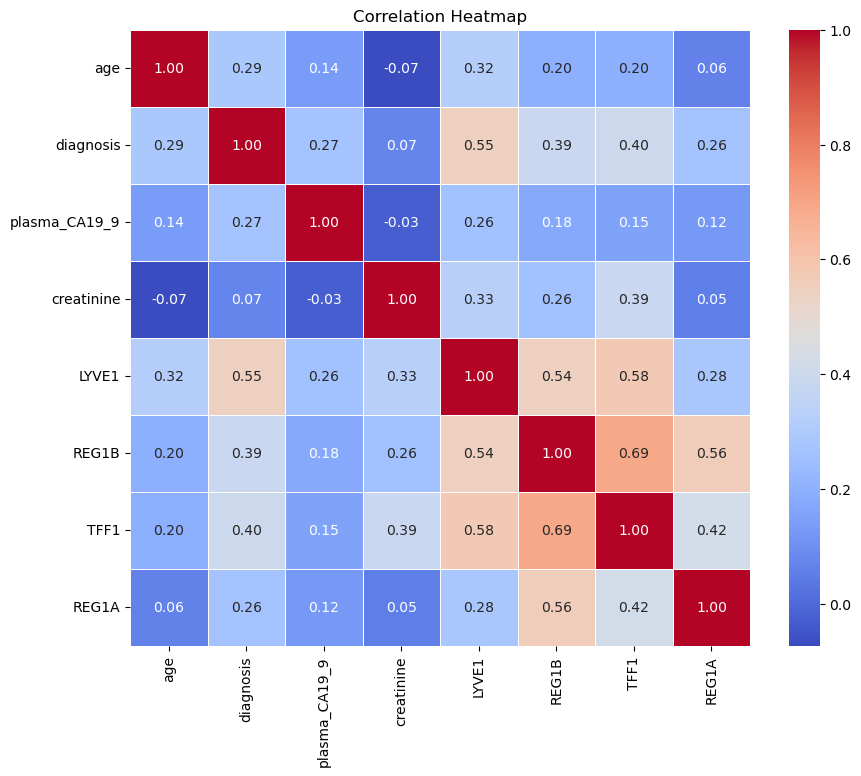

In [167]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


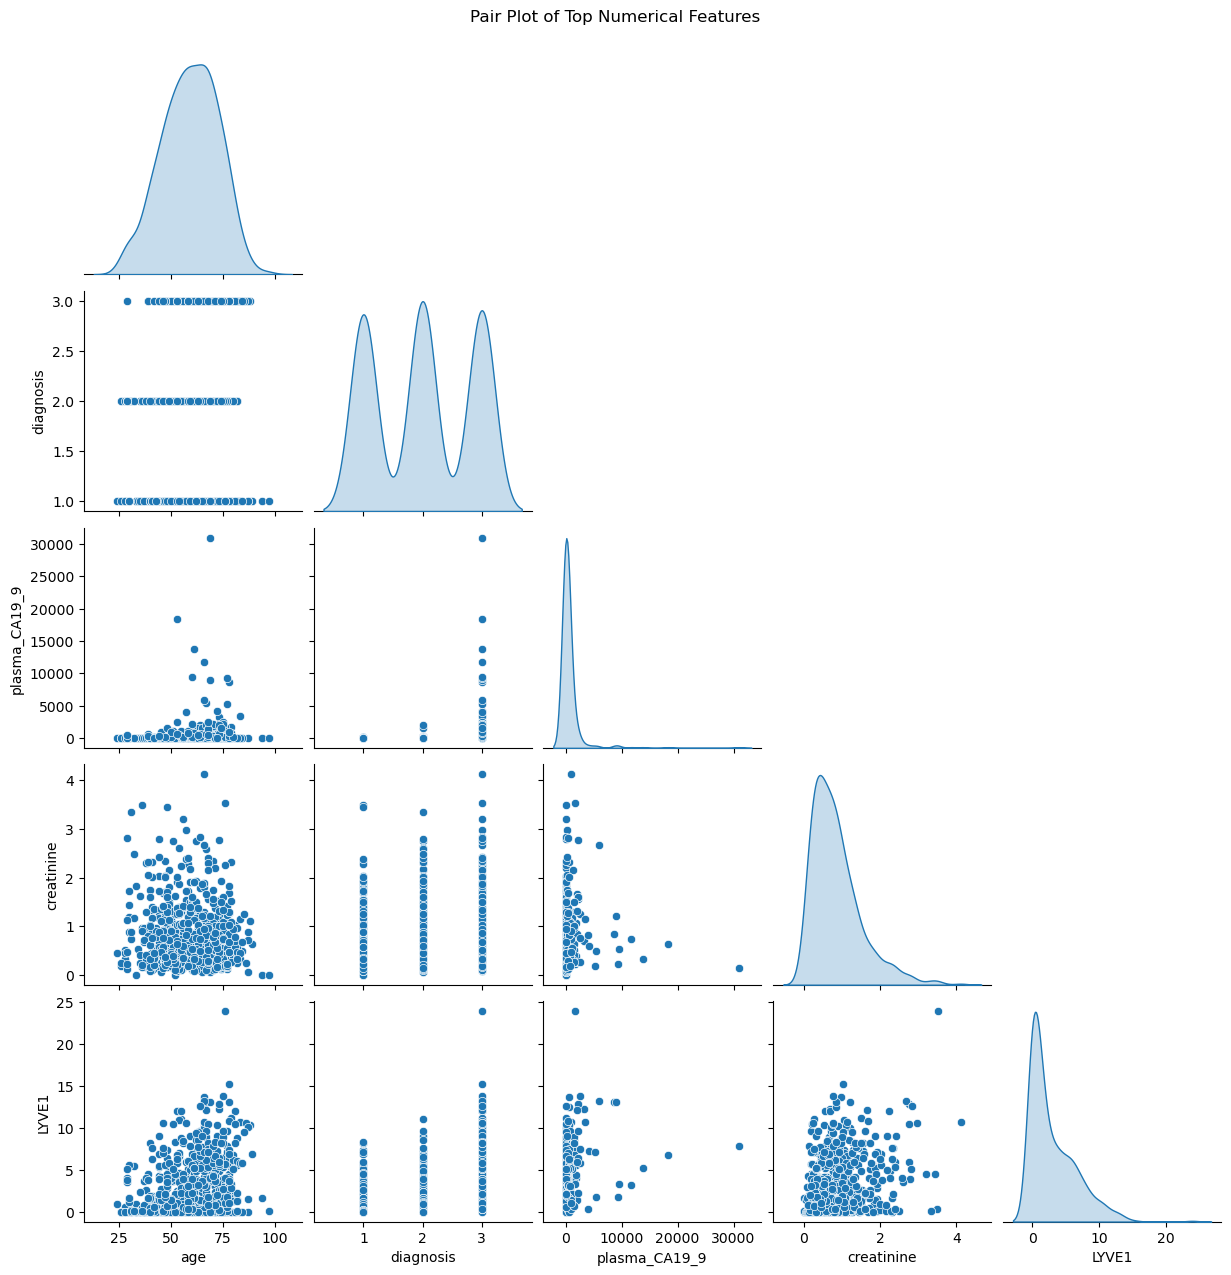

In [169]:
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
if len(numerical_columns) > 5:
    numerical_columns = numerical_columns[:5]  # Use only the first 5 numerical columns for pairplot
sns.pairplot(data[numerical_columns], diag_kind="kde", corner=True)
plt.suptitle("Pair Plot of Top Numerical Features", y=1.02)
plt.show()

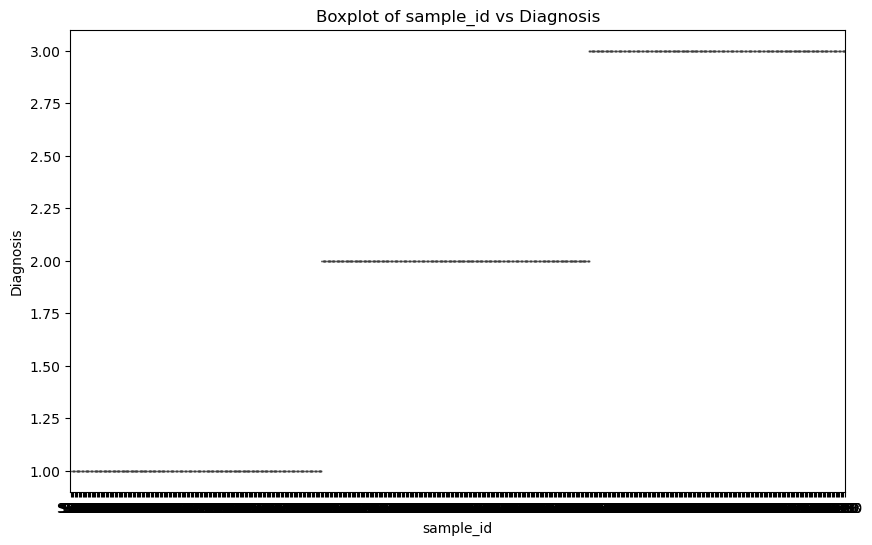

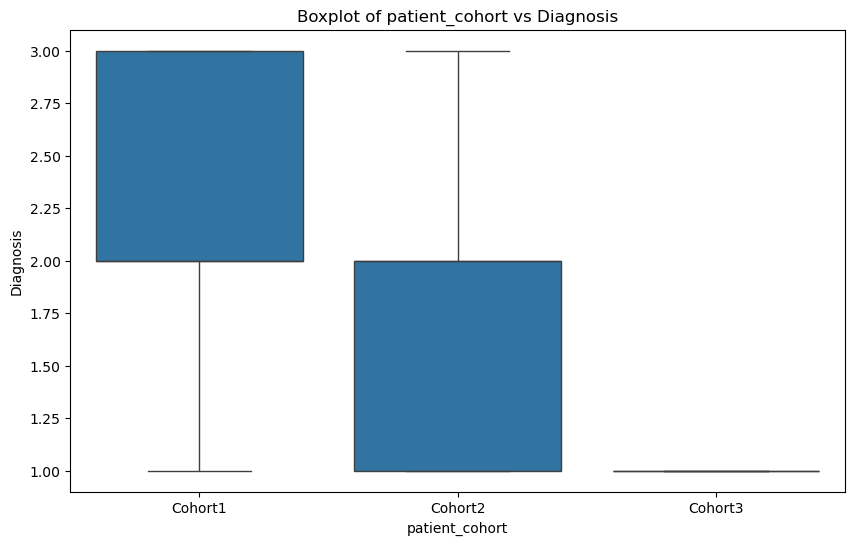

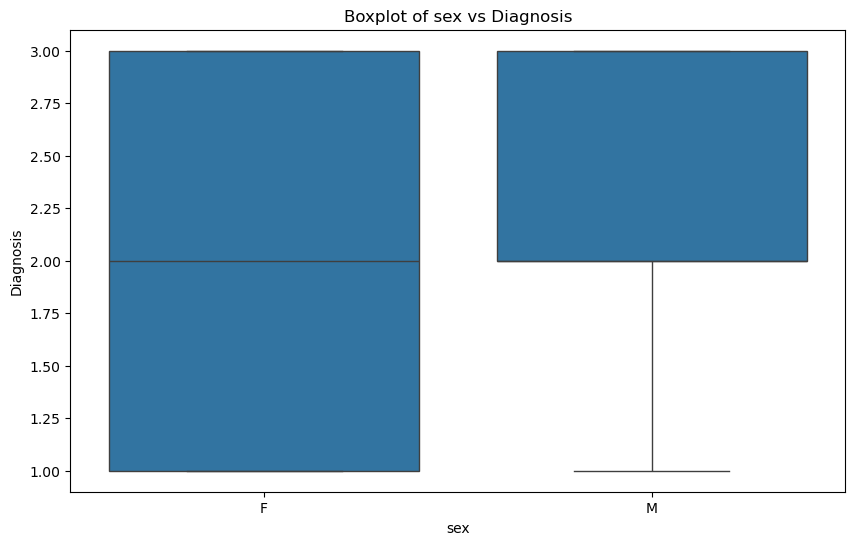

In [171]:
# Boxplots for Categorical vs Numerical Analysis
categorical_columns = ["sample_id", "patient_cohort", "sample_origin", "sex"]
for cat_col in categorical_columns:
    if cat_col in data.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=data[cat_col], y=data["diagnosis"], data=data)
        plt.title(f"Boxplot of {cat_col} vs Diagnosis")
        plt.xlabel(cat_col)
        plt.ylabel("Diagnosis")
        plt.show()

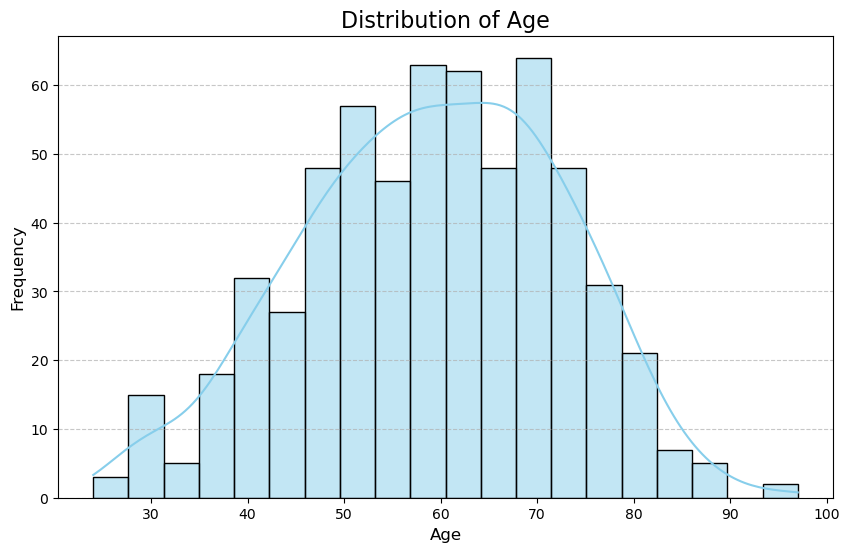

In [173]:
if "age" in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x="age", bins=20, kde=True, color="skyblue")
    plt.title("Distribution of Age", fontsize=16)
    plt.xlabel("Age", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print("The 'age' column is not present in the dataset.")

In [251]:
print(data.dtypes)

sampleBPTBorigin             int32
age                          int64
sex                          int32
diagnosis                    int64
stage                        int32
benign_sample_diagnosis      int32
plasma_CA19_9              float64
creatinine                 float64
LYVE1                      float64
REG1B                      float64
TFF1                       float64
REG1A                      float64
dtype: object


In [175]:
# Drop unnecessary columns
data = data.drop(columns=["sample_id", "patient_cohort"], errors='ignore')  # Ignore if missing

In [207]:
# Ensure column names are stripped of extra spaces
data.columns = data.columns.str.strip()

# Define categorical columns
categorical_columns = ["sampleBPTBorigin", "sex", "stage", "benign_sample_diagnosis"]

In [209]:
# Convert categorical columns to category dtype if they exist
for col in categorical_columns:
    if col in data.columns:
        data[col] = data[col].astype("category")

In [211]:

# Fill missing numeric values with median
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

In [213]:
# Fill missing categorical values with "Unknown"
for col in categorical_columns:
    data[col] = data[col].cat.add_categories("Unknown").fillna("Unknown")

In [215]:
# Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store for future use

In [217]:
# Separate features and target variable
X = data.drop(columns=["diagnosis"], errors='ignore')  # Drop target safely
y = data["diagnosis"].astype(str)  # Convert target to string

In [219]:
# Split data (before encoding target to ensure all labels are learned)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [221]:
# Encode target variable (Label Encoding)
y_le = LabelEncoder()
y_le.fit(y)  # Fit on full y to learn all labels
y_train = y_le.transform(y_train)
y_test = y_le.transform(y_test)

In [223]:
# Standardize features (after splitting to prevent data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [235]:
# Add Gaussian noise to features
def add_gaussian_noise(X, mean=0, std=0.9):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

In [237]:
# Add noise only to training data
X_train_scaled_noisy = add_gaussian_noise(X_train_scaled)

In [239]:
# Define models with regularization
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.1),  # Lower C for regularization
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, max_depth=4, min_samples_split=10),
    "Decision Tree": DecisionTreeClassifier(max_depth=4, random_state=42, min_samples_split=10),
    "SVM": SVC(C=0.1, kernel="linear"),  # Stronger regularization
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=4, learning_rate=0.05, random_state=42),
}

In [241]:

# Train and evaluate models
model_results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled_noisy, y_train)  # Use noisy data for training
    y_pred = model.predict(X_test_scaled)  # Test on clean test data
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    model_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
    }
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}\n")


Model: Logistic Regression
Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1-Score: 0.91

Model: Random Forest
Accuracy: 0.89
Precision: 0.91
Recall: 0.89
F1-Score: 0.89

Model: Decision Tree
Accuracy: 0.83
Precision: 0.89
Recall: 0.83
F1-Score: 0.83

Model: SVM
Accuracy: 0.90
Precision: 0.92
Recall: 0.90
F1-Score: 0.90

Model: K-Nearest Neighbors
Accuracy: 0.76
Precision: 0.82
Recall: 0.76
F1-Score: 0.75

Model: Naive Bayes
Accuracy: 0.79
Precision: 0.86
Recall: 0.79
F1-Score: 0.79

Model: Gradient Boosting
Accuracy: 0.90
Precision: 0.92
Recall: 0.90
F1-Score: 0.90



In [243]:
# Find the best model based on F1-Score
best_model_name = max(model_results, key=lambda x: model_results[x]['F1-Score'])
best_model_metrics = model_results[best_model_name]

print(f"Best Model: {best_model_name}")
print("Metrics:")
for metric, value in best_model_metrics.items():
    print(f"{metric}: {value:.2f}")

Best Model: Logistic Regression
Metrics:
Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1-Score: 0.91


In [245]:
# Save best model
with open("best_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)
print(f"Best Model ({best_model_name}) saved as 'best_model.pkl'.")

Best Model (Logistic Regression) saved as 'best_model.pkl'.


In [247]:
# Save the scaler
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)
print("Scaler saved as 'scaler.pkl'.")

Scaler saved as 'scaler.pkl'.


In [249]:
# Save label encoder
with open("labelencoder.pkl", "wb") as label_encoder_file:
    pickle.dump(y_le, label_encoder_file)
print("Label Encoder saved as 'labelencoder.pkl'.")

Label Encoder saved as 'labelencoder.pkl'.
